# A Monte Carlo program for the Newman-Moore triangular lattice Ising model

In [1]:
using DelimitedFiles
using Random; Random.seed!(0);
seed = 1111;
rng = MersenneTwister(seed);

const EqSteps = 100
const NumSteps = 1000 #Monte Carlo production steps

#k = 2
#L = 2^k
L = 65
N = L*L
Spin = fill(1,N);

In [2]:
#This is the data structure that relates up-triangles to spin indices
function make_up_triangle(L, N)
    UpTriangle = zeros(Int,N,3)
    for i = 1:N
        UpTriangle[i,1] = i
        UpTriangle[i,2] = i+1    
        UpTriangle[i,3] = i+L
        #fix PBCs
        if mod(i,L) == 0
            UpTriangle[i,2] = i + 1 - L
        end
        if (i+L)> N
            UpTriangle[i,3] = i + L - N
        end
    end
    return UpTriangle
end
UpTriangle = make_up_triangle(L, N);

In [3]:
#This is the inverse data structure that relates a spin index to its 3 up-triangles
function make_associated_tri(L, N)
    AssociatedTri = zeros(Int,N,3)
    for i = 1:N
        AssociatedTri[i,1] = i
        AssociatedTri[i,2] = i-1
        AssociatedTri[i,3] = i-L
        if mod(i-1+L,L) == 0
            AssociatedTri[i,2] = i - 1 + L
        end
        if i<(L+1) 
            AssociatedTri[i,3] = i + N - L
        end
    end
    return AssociatedTri
end
AssociatedTri = make_associated_tri(L, N);

In [4]:
#here is the brute force calculation of the energy
function Energy_Total(Energy,Spin)
    Energy = 0
    for i = 1:N
        Spin1 = Spin[UpTriangle[i,1]]
        Spin2 = Spin[UpTriangle[i,2]]
        Spin3 = Spin[UpTriangle[i,3]]
        Energy += Spin1 * Spin2 * Spin3  #J = 1
        end # limit all arithmetic to integers for as long as we can
    return Energy / 2
end #Energy_Total

Energy_Total (generic function with 1 method)

In [5]:
#here is the energy DIFFERENCE calculated from the local triangular plaquettes
function Energy_Diff(Spin,spin_index)
    
    Tri1 = AssociatedTri[spin_index,1]
    Tri2 = AssociatedTri[spin_index,2]
    Tri3 = AssociatedTri[spin_index,3]

    plaquette_factor = 0
    plaquette_factor -= Spin[UpTriangle[Tri1,2]] * Spin[UpTriangle[Tri1,3]]
    plaquette_factor -= Spin[UpTriangle[Tri2,1]] * Spin[UpTriangle[Tri2,3]]
    plaquette_factor -= Spin[UpTriangle[Tri3,1]] * Spin[UpTriangle[Tri3,2]]
    
    return Spin[spin_index] * plaquette_factor
end

# Energy_Diff can only take 4 values: -3, -1, 1, 3
# BUT, the non-positive values always result in acceptance
# so we only need to cache the value of exp(-dE / T) for 2 values of dE
# we'll store these values in a tuple of length 3, and get the
# acceptance prob by indexing with dE

Energy_Diff (generic function with 1 method)

In [6]:
function MetropolisAccept(DeltaE::Int, acceptance_ratios::NTuple{3, Float64})::Bool
    if DeltaE <= 0
        return true
    else
        rnum = rand(rng)  #random number for Metropolis
        if (acceptance_ratios[DeltaE] > rnum)
            return true
        end
    end
    return false
end

MetropolisAccept (generic function with 1 method)

In [7]:
Tarr = zeros(Float64,0)  
EMC = zeros(Float64,0)  
SpecHeat = zeros(Float64,0)  
Eexact = zeros(Float64,0)
Acceptance = zeros(Float64,0) 

const autocorr_steps = 100
const data_samples = 5000
const num_autocorrs = data_samples - autocorr_steps + 1

const gamma = 0.01
const stoptime = 10
for time = 0:stoptime
#for T = 10:-0.1:0.1  #count down  
    
    print(time," ")
    T = exp(-gamma*time)
    beta = 1.0/T
    
    acceptance_ratios = (exp(-beta*1), exp(-beta*2), exp(-beta*3))

    #initialize the energy
    Energy = 0
    Energy=Energy_Total(Energy,Spin)
    #println(Energy)

    for step = 1:EqSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(DeltaE, acceptance_ratios)
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
    end #Equilibration
    
    E_avg = 0
    E2 = 0
    A_rate = 0
    for step = 1:NumSteps
        Accept = 0
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(DeltaE, acceptance_ratios)
                Energy += DeltaE
                Spin[spin_i] *= -1
                Accept += 1
                end  
        end #i
        E_avg += Energy
        E2 += Energy*Energy
        A_rate += Accept/N
    end #Monte Carlo production step

    E_exact = 1/(1+exp(beta))
    Cv = E2/NumSteps - (E_avg/NumSteps)^2
    println(T," ",E_avg/NumSteps/N," ",E_exact-0.5," ",Cv/N/T/T," ",A_rate/NumSteps)
     
    push!(Tarr,T)
    push!(EMC,E_avg/NumSteps/N)
    push!(SpecHeat,Cv/(T*T*N))
    push!(Eexact,E_exact-0.5)
    push!(Acceptance,A_rate/NumSteps)
    
    #Let's write configuration files for data
    if time == stoptime
        println("Starting to get final data")        
        Tstring = first(string(T),8)
        filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime,
            "_T", Tstring, "_seed", seed, ".dat")
        mag_filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime,
            "_T", Tstring, "_seed", seed, "_mag.dat")
        
        autocorrs = zeros(autocorr_steps)
        Mag_array = zeros(data_samples)
        for step = 1:data_samples #configuration data files
            for i = 1:20*N  #multiple single spin flips
                spin_i = rand(1:N)
                DeltaE = Energy_Diff(Spin,spin_i)
                if MetropolisAccept(DeltaE, acceptance_ratios)
                    Energy += DeltaE
                    Spin[spin_i] *= -1
                    end 
                end #i
            Mag_array[step] = sum(Spin)

            open(filename, "a") do io
                writedlm(io, Spin' , " ")
                end # end open
            end #step 

        
        println("Writing magnetization data")
        
        # Save data with magnetizations
        open(mag_filename, "w") do io
            writedlm(io, Mag_array', " ")
            end #end open
        
    end #if stoptime

end #T

EMC_filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime,
        "_seed", seed, "_energy.dat")
open(EMC_filename, "w") do io
    writedlm(io, EMC', " ")
end #end open

temp_filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime, "_temperature.dat")
open(temp_filename, "w") do io
    writedlm(io, Tarr', " ")
end #end open

0 1.0 -0.23110059171597633 -0.2310585786300049 0.19246816568049058 0.3561730177514794
1 0.9900498337491681 -0.23347810650887574 -0.2330299669032307 0.20670558324465232 0.3509746745562128
2 0.9801986733067553 -0.23490958579881657 -0.2350118162075338 0.20576544501080363 0.34701846153846194
3 0.9704455335485082 -0.2365491124260355 -0.23700400723120663 0.20770367293222172 0.3424068639053255
4 0.9607894391523232 -0.23897207100591716 -0.23900641521388233 0.20182326528560043 0.33776923076923077
5 0.951229424500714 -0.2411955029585799 -0.2410189098634476 0.20425583160682412 0.33293254437869796
6 0.9417645335842487 -0.2433978698224852 -0.24304135527459575 0.21907204155583382 0.3280684023668645
7 0.9323938199059483 -0.24509585798816566 -0.24507360984918386 0.21789455522741025 0.32388426035502926
8 0.9231163463866358 -0.24661964497041422 -0.2471155262185617 0.22894071522523116 0.3195410650887574
9 0.9139311852712282 -0.24917230769230767 -0.24916695116804632 0.21555324553748229 0.31493514792899413

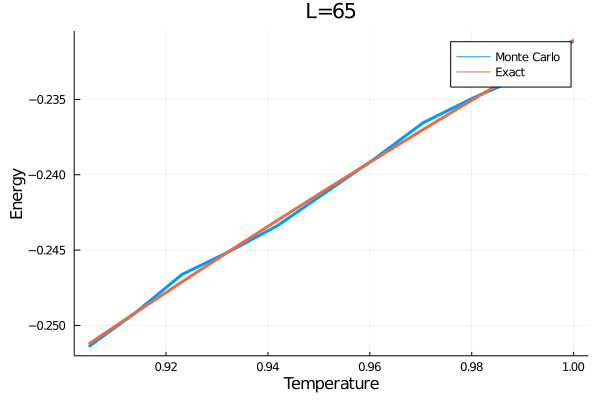

In [8]:
using Plots
Lstring = string("L=",L)
plot(Tarr, [EMC, Eexact], title = Lstring, label = ["Monte Carlo" "Exact"], lw = 3 )
xlabel!("Temperature")
ylabel!("Energy")

In [9]:
autocorr = (M_t_M_ti_avg .- M_t_avg * M_ti_avg) ./ (M_t_stdev * M_ti_stdev)
plot(1:100, autocorr, title="Magnetization Autocorrelation", label="L = 64", lw=3)
xlabel!("MC Step")
ylabel!("Autocorrelation")

UndefVarError: UndefVarError: M_t_avg not defined

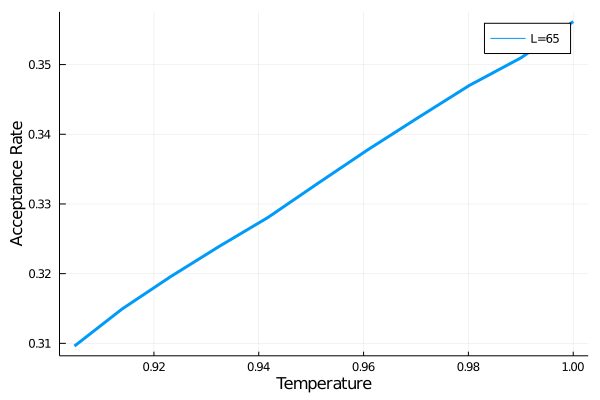

In [10]:
plot(Tarr, Acceptance, label = Lstring, lw = 3 )
xlabel!("Temperature")
ylabel!("Acceptance Rate")